In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from tqdm import tqdm

In [12]:
def process_algo1(int_1, int_2, int_j_1, int_j_2, P_raw, error_matrix, i, j, partition_n, nu):
    X_breaks = np.linspace(int_1, int_2,  partition_n + 1)
    for k in range(partition_n):
        a = X_breaks[k]
        b = X_breaks[k + 1]
        int_T_1 = min(T(a), T(b))
        int_T_2 = max(T(a), T(b))
        
        if int_T_1 > int_j_1 and int_T_2 < int_j_2:
            ### T(I_{i, k}) in I_j
            P_raw[i][j] += (b - a) / (max(int_j_1, int_j_2) - min(int_j_1, int_j_2)) # not sure about division
        elif int_T_1 > int_j_2 or int_T_2 < int_j_1:
            ### T(I_{i, k}) in I_j^C
            pass
        else:
            if b - a > nu:
                ### interval intersectrs both I_j and I_j^C and is bigger than nu
                process_algo1(a, b, int_j_1, int_j_2, P_raw, error_matrix, i, j, partition_n, nu)
            else:
                ### interval intersectrs both I_j and I_j^C and is smaller than nu
                error_matrix[i][j] += (b - a) / (max(int_j_1, int_j_2) - min(int_j_1, int_j_2)) # not sure about division
    
def process_algo2(int_1, int_2, int_j_1, int_j_2, P_raw, error_matrix, i, j, partition_n, monotone_partition_n, nu):
    X_breaks = np.linspace(int_1, int_2,  partition_n + 1)
    for k in range(partition_n):
        a = X_breaks[k]
        b = X_breaks[k + 1]
        
        direction = T(b) - T(a)
        I_breaks = np.linspace(a, b, monotone_partition_n + 1)
        is_monotone = True
        
        for t in range(monotone_partition_n):
            if np.sign(T(I_breaks[t+1]) - T(I_breaks[t])) != np.sign(T(b) - T(a)):
                is_monotone = False
                break   
        
        if k > 0:
            if np.sign(T(X_breaks[k]) - T(X_breaks[k-1])) != np.sign(T(X_breaks[k+1]) - T(X_breaks[k])):
                is_monotone = False
        
        if is_monotone:
            ### applying monotone algo1 for subinterval
            process_algo1(a, b, int_j_1, int_j_2, P_raw, error_matrix, i, j, partition_n, nu)
        else:
            if b - a > nu:
                ### interval is bigger than nu, iterating
                process_algo2(a, b, int_j_1, int_j_2, P_raw, error_matrix, i, j, partition_n, monotone_partition_n, nu)
            else:
                ### interval is smaller than nu, increasing error
                error_matrix[i][j] += (b - a) / (max(int_j_1, int_j_2) - min(int_j_1, int_j_2)) # not sure about division
    
    
def get_P_raw(partition_n=1000, monotone_partition_n=10, nu=0.001):
    
    print('Running algorithm for partition_n = {}'.format(partition_n))
    
    P_raw = np.zeros((partition_n, partition_n))
    error_matrix = np.zeros((partition_n, partition_n))
    X_breaks = np.linspace(0, 1, partition_n + 1)
    
    ### iterating by intervals in partition of X (X = [0, 1])
    
    for i in tqdm(range(partition_n)):
        
        a = X_breaks[i]
        b = X_breaks[i + 1]
        
        ### checking if T(x) is monotone on I
        
        direction = T(b) - T(a)
        I_breaks = np.linspace(a, b, monotone_partition_n + 1)
        is_monotone = True
        
        for j in range(monotone_partition_n):
            if np.sign(T(I_breaks[j+1]) - T(I_breaks[j])) != np.sign(T(b) - T(a)):
                is_monotone = False
                break   
        
        if i > 0:
            if np.sign(T(X_breaks[i]) - T(X_breaks[i-1])) != np.sign(T(X_breaks[i+1]) - T(X_breaks[i])):
                is_monotone = False
        
        if not is_monotone:
            print('T(x) has discontinuity on interval ({}, {})'.format(a, b))
            
        ### iterating by intervals in partition to calculate P_raw(i, j)    
            
        for j in range(partition_n):
            int_j_1 = X_breaks[j]
            int_j_2 = X_breaks[j + 1]
            if is_monotone:
                ### using algorithm 1 for monotone case
                process_algo1(a, b, int_j_1, int_j_2, P_raw, error_matrix, i, j, partition_n, nu)
                
            else:
                ### using algorithm 2 for non-monotone case
                process_algo2(a, b, int_j_1, int_j_2, P_raw, error_matrix, i, j, partition_n, monotone_partition_n, nu)
                
    print(P_raw)
    print(error_matrix)
    return P_raw, error_matrix
   

In [16]:
def T(x): 
    ### Lanford map (squared)
#     x = (2 * x + 0.5 * x * (1 - x)) % 1
    return (2 * x + 0.5 * x * (1 - x)) % 1
#     ### Manneville-Pomeau map
#     return (x + x ** 1.125) % 1
    ### not Markov map
#     return (3.4 * x) % 1

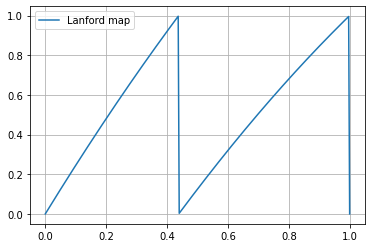

In [17]:
partition_n=300;
x_points = np.linspace(0, 1, partition_n + 1)
res = []
for i in range(len(x_points)):
    res.append(T(x_points[i]))
    
plt.plot(x_points, res,  label="Lanford map")
plt.grid()
plt.legend(loc='best')
plt.savefig("./Lanford.png")

In [18]:
P_raw, error_matrix = get_P_raw(partition_n=partition_n)

  0%|          | 0/300 [00:00<?, ?it/s]

Running algorithm for partition_n = 300


 44%|████▎     | 131/300 [00:48<01:01,  2.73it/s]

T(x) has discontinuity on interval (0.4366666666666667, 0.44)


 44%|████▍     | 132/300 [02:44<1:38:49, 35.29s/it]

T(x) has discontinuity on interval (0.44, 0.44333333333333336)


100%|█████████▉| 299/300 [05:44<00:00,  2.72it/s]  

T(x) has discontinuity on interval (0.9966666666666667, 1.0)


100%|██████████| 300/300 [07:42<00:00,  1.54s/it]

[[0.39666667 0.39666667 0.19666667 ... 0.         0.         0.        ]
 [0.         0.         0.2        ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.66       0.33       0.        ]
 [0.         0.         0.         ... 0.         0.33382222 0.66283333]]
[[0.00666667 0.00666667 0.00333333 ... 0.         0.         0.        ]
 [0.         0.         0.00333333 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00666667 0.00333333 0.        ]
 [0.00333333 0.00333333 0.00333333 ... 0.00333333 0.00334444 0.00334444]]


In [19]:
P_stoch = (P_raw.T / np.sum(P_raw, axis=1)).T

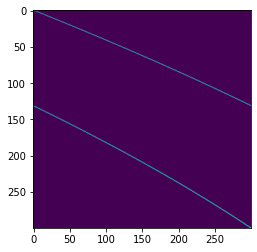

In [20]:
pylab.imshow((P_stoch))
pylab.show()

In [21]:
epsilon = np.max(error_matrix)
nnz = np.sum(np.where(P_raw > 0, 1, 0), axis=1)
NNZ = np.max(nnz)
total_max_error = NNZ * epsilon * 2
epsilon, nnz, total_max_error, NNZ

(0.006677777777758311,
 array([3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 3, 4, 3, 4,
        3, 4, 3, 3, 4, 3, 4, 3, 3, 4, 3, 4, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3,
        4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3,
        4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 4,
        3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
        3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3,
        3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3,
        3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2,
        3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2,
        3, 2, 3

In [22]:
### Now we have to compute N_e
basis = np.diag(np.ones(partition_n))
zero_basis = []
for i in range(1, partition_n):
    zero_basis.append(basis[0] - basis[i])
zero_basis = np.array(zero_basis)    
e_num = 0.0001
d = 1.0
N_e = 0
while d > e_num:
    for i in range(1, partition_n):
        zero_basis[i-1] = np.dot(zero_basis[i-1], P_stoch)
    d = 2 * np.max(np.sum(np.abs(zero_basis), axis=1))
    N_e += 1    
print(N_e)  

29


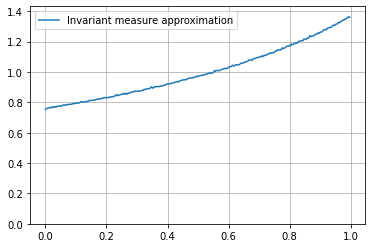

In [23]:
### Now we have markov chain approximating our system, so we need to calculate its's steady state
iterates = N_e
b0 = np.ones(P_stoch.shape[0])
for i in range(iterates):
    b0 = np.dot(b0, P_stoch)

plt.ylim(0, np.max(b0) * 1.05)
plt.plot(x_points[:-1], b0,  label="Invariant measure approximation")
plt.grid()
plt.legend(loc='best')
plt.savefig("./Lanford_map_invariant.png")